In [19]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
%matplotlib inline

import os
import pandas as pd
from pandas import factorize
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy import stats
#import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [20]:
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

In [41]:
import re
data_path = 'data/vis-open-x.csv'
df = pd.read_csv(data_path)
df.columns = [re.sub('[^A-Za-z0-9Δ%]+', '_', element) for element in df.columns]
df.columns  = [re.sub('%','_PCT',element) for element in df.columns]
n_fold = 5
n_subset = 5000#len(df)#5000

col_names = df.columns
cols_group = col_names[-23:] #residual identity
cols_second = ['Bsheet','aHelix','loop']
#cols_feature = col_names.difference(cols_group)
cols_feature = list(col_names)
df_x = df[cols_feature]
df_x = df_x.iloc[:n_subset,:]
        
data_path = 'data/vis-open-y.csv'
df_y = pd.read_csv(data_path)
df_y.columns = [re.sub('[^A-Za-z0-9Δ%]+', '_', element) for element in df_y.columns]
df_y.columns  = [re.sub('%','_PCT',element) for element in df_y.columns]
df_y = df_y.iloc[:n_subset,:]
#df_y = df_y*1000

arr_resi_ohe = df_x[cols_group].to_numpy()
arr_resi_label = np.where(arr_resi_ohe==1)[1]
df_x['residual_id'] = arr_resi_label


arr_second_ohe = df_x[cols_second].to_numpy()
arr_second_label = np.where(arr_second_ohe==1)[1]
df_x['second_id'] = arr_second_label

num_outputs = df_y.shape[1]
num_tasks = len(df_x['second_id'].unique())

print(df_x.shape)
print(df_y.shape)

(5000, 184)
(5000, 6)


In [42]:
ls_model = ['rf','simpleGP','multi-task-single-output','multi-task-multi-output','multi-task-multi-input-multi-output']
ls_x_scale = ['no-x-scale','x-minmax','x-stand','x-robust']
ls_y_scale = ['no-y-scale','y-minmax','y-stand','y-robust']
ls_cate_transform = ['label','ohe','LVGP','LMGP']
ls_remove_pred_outlier = [0,1]
ls_output_rank_option = [1,2]
ls_task_rank_option = [1,2,3,4,5,6,7]
ls_lik_rank_option = [0,1,2]
ls_split_option = ['mix','separate'] #mix: combine all tasks first then do train, test split (could stratify task?) #separate, do train-test-split first, then combine tasks
ls_stratify_task = ['not-stratify','stratify-x','stratify-y','stratify-xy']

In [43]:

model_option = 'simpleGP'
x_scale_option = 'x-stand'#'x-minmax'
y_scale_option = 'no-y-scale'#'y-minmax'#'y-stand'
cate_transform_option = 'none'
#remove_pred_outlier_option= 0

#output_rank_option = 1 #if 0, no correlation between output
task_rank_option = df_y.shape[1]#if 0, no correlation between tasks
lik_rank_option = 1
split_option = 'mix'
stratify_option = 'stratify-x'
noise_option = 0 #noise percentage

model_label = model_option
x_scale_label = x_scale_option
y_scale_label = y_scale_option
cate_transform_label = 'cate_transform_'+cate_transform_option
n_data_label = 'n_subset_'+str(n_subset)
n_output_label = 'n_output_'+str(num_outputs)
n_task_label = 'n_task_'+str(num_tasks)
n_fold_label = 'n_fold_'+str(n_fold)#treat each output as a batch

if model_option == 'multi-task-single-output' or  model_option =='multi-task-multi-output':
        task_rank_label = 'task_rank_'+str(task_rank_option)
        lik_rank_label = 'lik_rank_'+str(lik_rank_option)
else:
        task_rank_label = ''
        lik_rank_label = ''

if noise_option>0:
        noise_label = 'noise_'+str(noise_option)
else:
        noise_label = ''

folder_name = '-'.join([model_label,n_fold_label,x_scale_label,y_scale_label,cate_transform_label,
                        task_rank_label,lik_rank_label,noise_label,n_data_label,n_output_label,n_task_label])

figPath = 'output/vis-open-0827-singlegp/'+folder_name
if not os.path.exists(figPath):
        print(f'Creating folder {figPath}')
        os.makedirs(figPath,exist_ok = True)

In [44]:
def rf_sklearn(X_train,y_train,X_test,y_test,feature_names,tmp_col_y,figPath,is_plot_imp = False):
    rf = RandomForestRegressor(random_state= 10)
    rf.fit(X_train,y_train)
    y_train_pred = rf.predict(X_train)
    y_pred = rf.predict(X_test)
    """
    test_var = metrics.mean_squared_error(y_test, y_pred)
    train_var = metrics.mean_squared_error(y_train, y_train_pred)
    test_std = np.sqrt(test_var)
    train_std = np.sqrt(train_var)
    """

    test_std = np.abs(y_test - y_pred)
    train_std = np.abs(y_train - y_train_pred)
    
    importances=rf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

    forest_importances = pd.Series(importances, index=feature_names)

    if is_plot_imp:
        fig, ax = plt.subplots()
        forest_importances.plot.bar(yerr=std, ax=ax)
        ax.set_title(tmp_col_y + " Feature importances")
        ax.set_ylabel("Mean decrease in impurity")
        fig.tight_layout()
        figName = tmp_col_y + 'featureImp.jpg'
        plt.savefig(os.path.join(figPath,figName))
    
    return y_train_pred, train_std, y_pred, test_std, forest_importances

In [45]:
#define a Batch GP Model
class BatchIndependentMultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_outputs]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_outputs])),
            batch_shape=torch.Size([num_outputs])
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal.from_batch_mvn(
            gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        )

In [46]:
def mdape(y_true, y_pred):
    """
    Calculate the Median Absolute Percentage Error (MdAPE).

    Parameters:
    y_true (array-like): True values.
    y_pred (array-like): Predicted values.

    Returns:
    float: MdAPE value.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    ape = np.abs((y_true - y_pred) / y_true) * 100
    return np.median(ape)

#mdape_value = mdape(y_true, y_pred)
#print(f"MdAPE: {mdape_value:.2f}%")

In [47]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=n_fold, shuffle=True,random_state=0)

ls_X_train = []
ls_X_test = []
ls_y_train = []
ls_y_test = []
ls_y_scaler = []
X = df_x[cols_feature].to_numpy()
Y = df_y.to_numpy()

for train_ix, test_ix in kfold.split(X):
    X_train, X_test=X[train_ix,:], X[test_ix,:]
    y_train, y_test= Y[train_ix],Y[test_ix]

    if x_scale_label != 'no-x-scale':
        x_scaler = StandardScaler()
        scaled_X_train=x_scaler.fit_transform(X_train) 
        scaled_X_test=x_scaler.transform(X_test)
    else:
        scaled_X_train= X_train
        scaled_X_test=X_test

    if y_scale_label == 'y-robust':
        y_scaler = RobustScaler()
        scaled_y_train = y_scaler.fit_transform(y_train)
    elif y_scale_label == 'y-stand':
        y_scaler = StandardScaler()
        scaled_y_train = y_scaler.fit_transform(y_train)
    elif y_scale_label == 'y-minmax':
        y_scaler = MinMaxScaler()
        scaled_y_train = y_scaler.fit_transform(y_train)
    else:
        scaled_y_train = y_train

    if y_scale_label!='no-y-scale':
        ls_y_scaler.append(y_scaler)
    
    ls_X_train.append(torch.Tensor(scaled_X_train))
    ls_X_test.append(torch.Tensor(scaled_X_test))
    ls_y_train.append(torch.Tensor(scaled_y_train))
    ls_y_test.append(torch.Tensor(y_test))

In [48]:
"""
##Split the data into training and testing sets
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df_x, df_y, 
                                                                test_size=0.2, random_state=0,
                                                                stratify=df_x['second_id'])

xct = ColumnTransformer([('x_scaler',StandardScaler(),df_X_train.columns.difference(['second_id']))], 
                         remainder = 'passthrough')

scaled_X_train=xct.fit_transform(df_X_train) 
scaled_X_test=xct.transform(df_X_test)

if x_scale_label != 'no-x-scale':
        t_train_x = torch.Tensor(scaled_X_train)
        t_test_x = torch.Tensor(scaled_X_test)
else:
        t_train_x = torch.Tensor(df_X_train.to_numpy())
        t_test_x = torch.Tensor(df_X_test.to_numpy())

if model_option == 'simpleGP':
    if y_scale_label == 'y-robust':
        y_scaler = RobustScaler()
        scaled_y_train = y_scaler.fit_transform(df_y_train)
    elif y_scale_label == 'y-stand':
        y_scaler = StandardScaler()
        scaled_y_train = y_scaler.fit_transform(df_y_train)
    elif y_scale_label == 'y-minmax':
        y_scaler = MinMaxScaler()
        scaled_y_train = y_scaler.fit_transform(df_y_train)
    else:
        scaled_y_train = df_y_train.to_numpy()
    t_train_y= torch.Tensor(scaled_y_train)
"""

"\n##Split the data into training and testing sets\ndf_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df_x, df_y, \n                                                                test_size=0.2, random_state=0,\n                                                                stratify=df_x['second_id'])\n\nxct = ColumnTransformer([('x_scaler',StandardScaler(),df_X_train.columns.difference(['second_id']))], \n                         remainder = 'passthrough')\n\nscaled_X_train=xct.fit_transform(df_X_train) \nscaled_X_test=xct.transform(df_X_test)\n\nif x_scale_label != 'no-x-scale':\n        t_train_x = torch.Tensor(scaled_X_train)\n        t_test_x = torch.Tensor(scaled_X_test)\nelse:\n        t_train_x = torch.Tensor(df_X_train.to_numpy())\n        t_test_x = torch.Tensor(df_X_test.to_numpy())\n\nif model_option == 'simpleGP':\n    if y_scale_label == 'y-robust':\n        y_scaler = RobustScaler()\n        scaled_y_train = y_scaler.fit_transform(df_y_train)\n    elif y_s

In [49]:
def singleGP_gpytorch(t_train_x,t_test_x,t_train_y,training_iter = 50,fold_id = 0,pre_model = None):
    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_outputs)
    model = BatchIndependentMultitaskGPModel(t_train_x, t_train_y, likelihood)
    if fold_id>0:
        print(pre_model.covar_module.base_kernel.lengthscale)
        print(pre_model.likelihood.noise)
        model.covar_module.base_kernel.lengthscale = pre_model.covar_module.base_kernel.lengthscale
        model.likelihood.noise = pre_model.likelihood.noise
    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    training_iterations = 100
    loss_list = []
    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(t_train_x)
        loss = -mll(output, t_train_y)
        loss_list.append(loss.item())
        loss.backward()
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
        optimizer.step()

    #plt.plot(loss_list)
    #plt.title('Neg. Loss', fontsize='small')

    # Set into eval mode
    model.eval()
    likelihood.eval()

    # Make predictions
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        predictions = likelihood(model(t_test_x))
        test_mean = predictions.mean
        test_lower, test_upper = predictions.confidence_region()

        train_predictions = likelihood(model(t_train_x))
        train_mean = train_predictions.mean
        train_lower, train_upper = train_predictions.confidence_region()
    return model, test_mean, test_lower, test_upper, train_mean, train_lower, train_upper

In [13]:
from joblib import dump, load
# Save the model to a file
#dump(model, figPath+'/fold_'+str(fold_id)+'_singlegp_model.joblib')

['output/vis-open-0827-singlegp/simpleGP-n_fold_6-x-stand-no-y-scale-cate_transform_none----n_subset_20000-n_output_6-n_task_3/simplegp_model.joblib']

Iter 1/100 - Loss: 1.286
Iter 2/100 - Loss: 1.272
Iter 3/100 - Loss: 1.241
Iter 4/100 - Loss: 1.208
Iter 5/100 - Loss: 1.175
Iter 6/100 - Loss: 1.138
Iter 7/100 - Loss: 1.101
Iter 8/100 - Loss: 1.064
Iter 9/100 - Loss: 1.025
Iter 10/100 - Loss: 0.986
Iter 11/100 - Loss: 0.945
Iter 12/100 - Loss: 0.904
Iter 13/100 - Loss: 0.863
Iter 14/100 - Loss: 0.820
Iter 15/100 - Loss: 0.777
Iter 16/100 - Loss: 0.734
Iter 17/100 - Loss: 0.689
Iter 18/100 - Loss: 0.644
Iter 19/100 - Loss: 0.599
Iter 20/100 - Loss: 0.553
Iter 21/100 - Loss: 0.507
Iter 22/100 - Loss: 0.461
Iter 23/100 - Loss: 0.414
Iter 24/100 - Loss: 0.366
Iter 25/100 - Loss: 0.318
Iter 26/100 - Loss: 0.270
Iter 27/100 - Loss: 0.222
Iter 28/100 - Loss: 0.173
Iter 29/100 - Loss: 0.124
Iter 30/100 - Loss: 0.075
Iter 31/100 - Loss: 0.026
Iter 32/100 - Loss: -0.023
Iter 33/100 - Loss: -0.073
Iter 34/100 - Loss: -0.122
Iter 35/100 - Loss: -0.172
Iter 36/100 - Loss: -0.221
Iter 37/100 - Loss: -0.271
Iter 38/100 - Loss: -0.321
Iter 39/100 - 

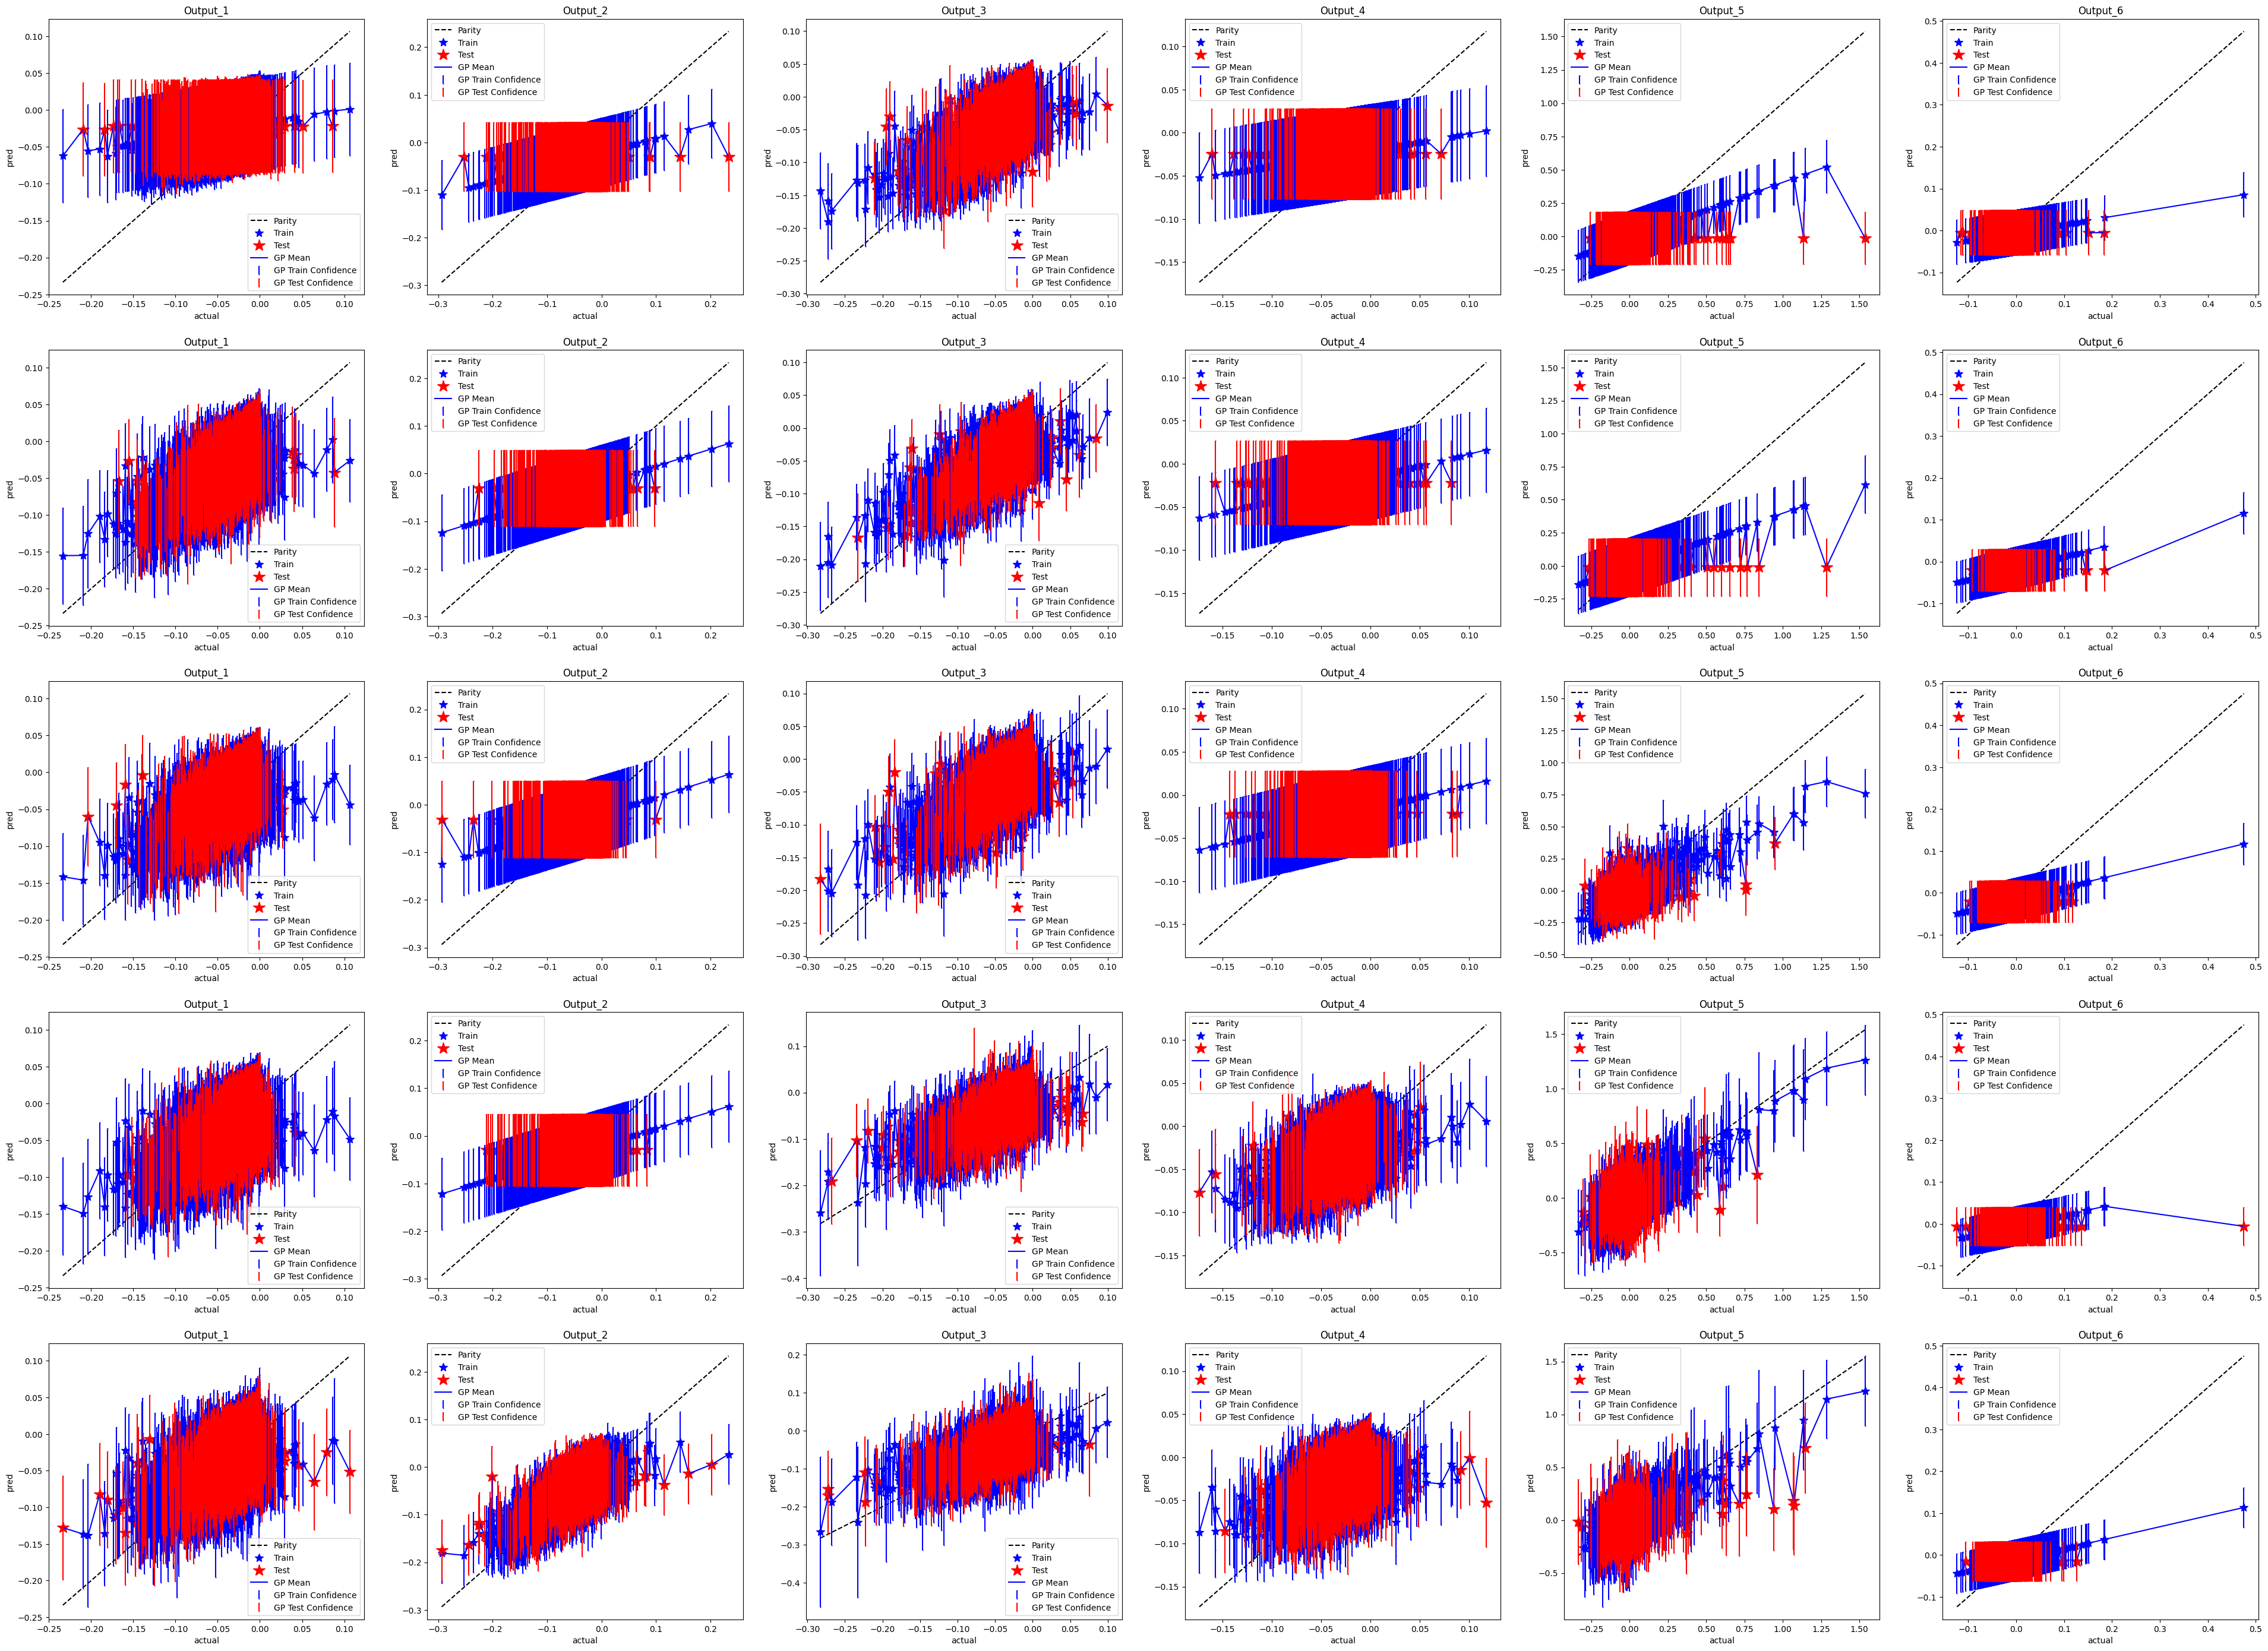

In [50]:
#plotting and analyses
cols_target = list(df_y.columns)

y_plot_scale_label='no-y-scale'

uncertainty_figure_option = 'errorbar' #shade or errorbar
is_set_axis_limit = False

plot_axis_lb = df_y.min(axis = 0) - 0.4*df_y.std(axis = 0)
plot_axis_ub = df_y.max(axis = 0) + 0.4* df_y.std(axis = 0)

num_tasks = n_fold
num_total_output = num_outputs*num_tasks
arr_train_metrics = np.zeros((11,num_total_output))
arr_test_metrics = np.zeros((11,num_total_output))

# Initialize plots
f, y_axes = plt.subplots(num_tasks, num_outputs, figsize=(num_outputs*8, num_tasks*7))
y_axes = y_axes.ravel()
cols_target_wide = []

for task_ind in range(num_tasks):
    t_train_x, t_test_x,t_train_y, t_test_y= ls_X_train[task_ind],ls_X_test[task_ind],ls_y_train[task_ind],ls_y_test[task_ind]
    if task_ind == 0:
        model,test_mean,test_lower,test_upper,train_mean,train_lower,train_upper = singleGP_gpytorch(t_train_x,t_test_x,t_train_y,training_iter = 50,fold_id = task_ind)
    else:    
        model,test_mean,test_lower,test_upper,train_mean,train_lower,train_upper = singleGP_gpytorch(t_train_x,t_test_x,t_train_y,training_iter = 50,fold_id = task_ind,pre_model = model)
    dump(model, figPath+'/fold_'+str(task_ind)+'_singlegp_model.joblib')

    
    #arr_test_y_all = df_y_test.to_numpy()
    arr_test_y_all =t_test_y.detach().numpy()
    if y_scale_label=='no-y-scale':
        arr_train_y_all = t_train_y.detach().numpy()
        arr_test_mean = test_mean.detach().numpy()
        arr_test_lower = test_lower.detach().numpy()
        arr_test_upper = test_upper.detach().numpy()

        arr_train_mean = train_mean.detach().numpy()
        arr_train_lower = train_lower.detach().numpy()
        arr_train_upper = train_upper.detach().numpy()
    else:
        y_scaler = ls_y_scaler[task_ind]
        arr_train_y_all = y_scaler.inverse_transform(t_train_y)
        arr_train_mean = y_scaler.inverse_transform(train_mean)
        arr_train_lower = y_scaler.inverse_transform(train_lower)
        arr_train_upper = y_scaler.inverse_transform(train_upper)

        arr_test_mean = y_scaler.inverse_transform(test_mean)
        arr_test_lower = y_scaler.inverse_transform(test_lower)
        arr_test_upper = y_scaler.inverse_transform(test_upper)
    
    for j,_ in enumerate(cols_target):
        a = j+num_outputs*task_ind
        tmp_col_y = 'Task_'+str(task_ind+1)+'_Output_'+str(j+1)
        cols_target_wide.append(tmp_col_y)
      

        y_true = arr_test_y_all[:,j]
        y_pred = arr_test_mean[:,j]
        y_train = arr_train_y_all[:,j]
        mean_train_pred = arr_train_mean[:,j]
        std_train_pred = arr_train_mean[:,j] - arr_train_lower[:,j]
        std_test_pred = arr_test_mean[:,j] - arr_test_lower[:,j]

        train_comp = np.concatenate((y_train.reshape(-1,1),mean_train_pred.reshape(-1,1)),axis = 1)
        df_train_comp = pd.DataFrame(train_comp,columns = ['true','pred'])
        df_train_comp['upper'] = df_train_comp['pred'] + std_train_pred.squeeze()
        df_train_comp['lower'] = df_train_comp['pred'] - std_train_pred.squeeze()
        df_train_comp['mode'] = 'train'
    
        test_comp = np.concatenate((y_true.reshape(-1,1),y_pred.reshape(-1,1)),axis = 1)
        df_test_comp = pd.DataFrame(test_comp,columns = ['true','pred'])
        df_test_comp['upper'] = df_test_comp['pred'] + std_test_pred.squeeze()
        df_test_comp['lower'] = df_test_comp['pred'] - std_test_pred.squeeze()
        df_test_comp['mode'] = 'test'
    
        df_comp = pd.concat([df_train_comp,df_test_comp])
        df_comp_sorted = df_comp.sort_values(by = ['true'],ascending=True)

        #plot a parity line
        y_axes[a].plot(df_comp_sorted['true'], df_comp_sorted['true'], '--',c = 'black')
    
        # Plot training data as blue stars
        y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'blue',markersize=10)

        # Plot training data as red stars
        y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'k*',c = 'red',markersize=15)
        # Predictive mean as blue line
        y_axes[a].plot(df_comp_sorted['true'], df_comp_sorted['pred'],c = 'blue')
    
        if model_option != 'rf':
          if uncertainty_figure_option == 'shade':
          # Shade in confidence
            y_axes[a].fill_between(x = df_comp_sorted['true'],y1 = df_comp_sorted['lower'], y2 = df_comp_sorted['upper'], color='b', alpha=.15)
          else:
            yerr = df_comp_sorted['pred'] - df_comp_sorted['lower']
            yerr = yerr.values.tolist()
            yerr_train = df_train_comp['pred'] - df_train_comp['lower']
            yerr_train = yerr_train.values.tolist()
            yerr_test = df_test_comp['pred'] - df_test_comp['lower']
            yerr_test = yerr_test.values.tolist()
            y_axes[a].errorbar(x = df_train_comp['true'], y = df_train_comp['pred'], yerr = yerr_train, capsize=1, fmt='none', ecolor = 'blue')
            y_axes[a].errorbar(x = df_test_comp['true'], y = df_test_comp['pred'], yerr = yerr_test, capsize=1, fmt='none', ecolor = 'red')
    
        if is_set_axis_limit:
          y_axes[a].set_xlim([plot_axis_lb[j],plot_axis_ub[j]])
          y_axes[a].set_ylim([plot_axis_lb[j],plot_axis_ub[j]])

        if model_option == 'rf':
          y_axes[a].legend(['Parity','Train','Test','GP Mean'])
        else:
          y_axes[a].legend(['Parity','Train','Test','GP Mean','GP Train Confidence','GP Test Confidence'])
        y_axes[a].set_title('Output_'+str(j+1))
        y_axes[a].set_xlabel('actual')
        y_axes[a].set_ylabel('pred')
    

        arr_test_metrics[0,a] = metrics.mean_absolute_error(y_true, y_pred)
        arr_test_metrics[1,a] = metrics.median_absolute_error(y_true, y_pred)
        arr_test_metrics[2,a] = metrics.mean_squared_error(y_true, y_pred)
        arr_test_metrics[3,a] = metrics.root_mean_squared_error(y_true, y_pred)
        arr_test_metrics[4,a] = mdape(y_true, y_pred)
        arr_test_metrics[5,a] = metrics.max_error(y_true, y_pred)
        arr_test_metrics[6,a] = metrics.explained_variance_score(y_true, y_pred)
        arr_test_metrics[7,a] = metrics.r2_score(y_true, y_pred)
        if model_option != 'rf':
          arr_test_metrics[8,a] = np.mean(std_test_pred)
          arr_test_metrics[9,a] = np.min(std_test_pred)
          arr_test_metrics[10,a] = np.max(std_test_pred)

        arr_train_metrics[0,a] = metrics.mean_absolute_error(y_train, mean_train_pred)
        arr_train_metrics[1,a] = metrics.median_absolute_error(y_train, mean_train_pred)
        arr_train_metrics[2,a] = metrics.mean_squared_error(y_train, mean_train_pred)
        arr_train_metrics[3,a] = metrics.root_mean_squared_error(y_train, mean_train_pred)
        arr_train_metrics[4,a] = mdape(y_train, mean_train_pred)
        arr_train_metrics[5,a] = metrics.max_error(y_train, mean_train_pred)
        arr_train_metrics[6,a] = metrics.explained_variance_score(y_train, mean_train_pred)
        arr_train_metrics[7,a] = metrics.r2_score(y_train, mean_train_pred)
        if model_option != 'rf':
          arr_train_metrics[8,a] = np.mean(std_train_pred)
          arr_train_metrics[9,a] = np.min(std_train_pred)
          arr_train_metrics[10,a] = np.max(std_train_pred)

if uncertainty_figure_option == 'shade' and is_set_axis_limit:
    plt.savefig(figPath+'/true-pred-shade.jpg')
elif uncertainty_figure_option == 'shade' and ~is_set_axis_limit:
    plt.savefig(figPath+'/true-pred-shade-zoomin.jpg')
elif uncertainty_figure_option == 'errorbar' and is_set_axis_limit:
    plt.savefig(figPath+'/true-pred-errorbar.jpg')
elif uncertainty_figure_option == 'errorbar' and ~is_set_axis_limit:
    plt.savefig(figPath+'/true-pred-errorbar-zoomin.jpg')

# Set global display precision to 2 decimal places
pd.set_option('display.precision', 2)

df_test_metrics = pd.DataFrame(arr_test_metrics,columns = cols_target_wide, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2','AVG_STD','MIN_STD','MAX_STD'])
print(df_test_metrics)

df_train_metrics = pd.DataFrame(arr_train_metrics,columns = cols_target_wide, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2','AVG_STD','MIN_STD','MAX_STD'])
print(df_train_metrics)

df_train_metrics.to_csv(figPath+'/df_train_metrics.csv')
df_test_metrics.to_csv(figPath+'/df_test_metrics.csv')